<a href="https://colab.research.google.com/github/jjsilvera/data-science-portfolio/blob/main/Cluster_Madrid_cafeteria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyze Districts in Madrid to open a cafeteria

## Description

Madrid is the capital of Spain and its largest city. It is located in the center of the peninsula, as the capital of Spain Madrid has the seat of government, the Court and is also the official residence of the King and Queen of Spain.
On the economic level, Madrid is home to the headquarters of many national and international companies. Culturally, Madrid has world-famous museums such as the Prado Museum and the Reina Sofia Museum. Madrid's neighborhoods are full of history and peculiar characteristics that make them unique.


Madrid stands out for the infinity of bars, restaurants and cafes in its streets. No doubt in every walk through the city we discover new places and the list of places to go is getting longer and longer.
This project aims to help by analyzing the characteristics of the districts of Madrid, its impact on the COVID combined with the data and datasets of the city, will determine the best or possible locations for a new restaurant type cafeteria.

## Data description

The data will be collected from different Madrid official soruces all of them with real and current data

* COVID datasets distributed by districts: https://datos.comunidad.madrid/catalogo/dataset/covid19_tia_muni_y_distritos/resource/877fa8f5-cd6c-4e44-9df5-0fb60944a841
* Neighborhoods an districts information: https://datos.gob.es/en/catalogo/a13002908-covid-19-tia-por-municipios-y-distritos-de-madrid1
* Prominents Madrid's data: https://datos.madrid.es/portal/site/egob/menuitem.ca8ea3bd9f53b2811ff64a46a8a409a0/?vgnextoid=6db862c549810510VgnVCM1000008a4a900aRCRD&vgnextchannel=6db862c549810510VgnVCM1000008a4a900aRCRD&vgnextfmt=default
* District's numbers: https://www.madrid.es/portales/munimadrid/es/Inicio/El-Ayuntamiento/Estadistica/Distritos-en-cifras/Distritos-en-cifras-Informacion-de-Distritos-/?vgnextfmt=default&vgnextoid=74b33ece5284c310VgnVCM1000000b205a0aRCRD&vgnextchannel=27002d05cb71b310VgnVCM1000000b205a0aRCRD#

## Venue data

The data will be extracted from the API Foursquare wich has large numbers of venues throughout the different districts

**Import libraries**

In [ ]:
import random
from IPython.display import Image
from IPython.core.display import HTML
from pandas.io.json import json_normalize
import geocoder
from geopy.geocoders import Nominatim
import folium
from folium import plugins
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs
from bs4 import BeautifulSoup
import requests
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### Data analysis and wrangling
The csv file is taken from the links given above

In [ ]:
madrid_data = pd.read_csv('Barrios.csv', sep=";", encoding='latin-1')
madrid_data.head()

,OBJECTID_1,DISTRICT,NEIGHBORHOOD,DISTRICT_LATITUDE,DISTRICT_LONGITUDE,Shape_Leng,Shape_Area,COD_DIS,COD_DIS_TX,BARRIO_MAY,COD_DISBAR,COD_BAR,NUM_BAR,BARRIO_MT,COD_DISB
0,60,Centro,Palacio,40.415347,-3.707371,"5754,822748","1469905,684",1,1,PALACIO,11,11,1,PALACIO,1_1
1,50,Centro,Embajadores,40.415347,-3.707371,"4275,227681","1033724,698",1,1,EMBAJADORES,12,12,2,EMBAJADORES,1_2
2,55,Centro,Cortes,40.415347,-3.707371,"3731,07903","591874,1219",1,1,CORTES,13,13,3,CORTES,1_3
3,64,Centro,Justicia,40.415347,-3.707371,"3597,421427","739414,338",1,1,JUSTICIA,14,14,4,JUSTICIA,1_4
4,66,Centro,Universidad,40.415347,-3.707371,"4060,075813","948027,0773",1,1,UNIVERSIDAD,15,15,5,UNIVERSIDAD,1_5


In [ ]:
madrid_data.drop(['OBJECTID_1','Shape_Leng','Shape_Area', ], axis = 1, inplace=True)
madrid_data.head()

,DISTRICT,NEIGHBORHOOD,DISTRICT_LATITUDE,DISTRICT_LONGITUDE,COD_DIS,COD_DIS_TX,BARRIO_MAY,COD_DISBAR,COD_BAR,NUM_BAR,BARRIO_MT,COD_DISB
0,Centro,Palacio,40.415347,-3.707371,1,1,PALACIO,11,11,1,PALACIO,1_1
1,Centro,Embajadores,40.415347,-3.707371,1,1,EMBAJADORES,12,12,2,EMBAJADORES,1_2
2,Centro,Cortes,40.415347,-3.707371,1,1,CORTES,13,13,3,CORTES,1_3
3,Centro,Justicia,40.415347,-3.707371,1,1,JUSTICIA,14,14,4,JUSTICIA,1_4
4,Centro,Universidad,40.415347,-3.707371,1,1,UNIVERSIDAD,15,15,5,UNIVERSIDAD,1_5


In [ ]:
madrid_data.drop(['COD_DIS','COD_DIS_TX','BARRIO_MAY','COD_DISBAR','COD_BAR','NUM_BAR','BARRIO_MT','COD_DISB'], axis = 1, inplace=True)
madrid_data.head()

,DISTRICT,NEIGHBORHOOD,DISTRICT_LATITUDE,DISTRICT_LONGITUDE
0,Centro,Palacio,40.415347,-3.707371
1,Centro,Embajadores,40.415347,-3.707371
2,Centro,Cortes,40.415347,-3.707371
3,Centro,Justicia,40.415347,-3.707371
4,Centro,Universidad,40.415347,-3.707371


Madrid latitude and longitude:

In [ ]:
city = 'Madrid, MAD'
geolocator = Nominatim(user_agent="madrid")
location = geolocator.geocode(city)
latitude = location.latitude
longitude = location.longitude
print("Madrid latitude: ", location.latitude, "\n", "Madrid longitude: ", location.longitude)

Madrid latitude:  40.4948384 
 Madrid longitude:  -3.5740806206811313


In [ ]:
# this is another way using Nominatim passing the coordinates we can see its name

geolocator = Nominatim(user_agent = "url")
location = geolocator.reverse("40.4948384 , -3.5740806206811313")
print(location.address)

Aeropuerto de Madrid-Barajas Adolfo Suárez, Barajas, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28001, España


**Madrid map with districts and neighborhoods:**

In [ ]:
# create map of Madrid using latitude and longitude values
madrid_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, district, neighborhood in zip(madrid_data['DISTRICT_LATITUDE'],madrid_data['DISTRICT_LONGITUDE'],madrid_data['DISTRICT'],madrid_data['NEIGHBORHOOD']):
    label = '{}, {}'.format(neighborhood,district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(madrid_map)

madrid_map


In [ ]:
# API Foursquare
CLIENT_ID = 'IYJ1TPEJFEWISEQRDNZNXO4HJQ0MTMY0AVDGBJBOLUEYAGH0' # your Foursquare ID
CLIENT_SECRET = 'HSVKU5JZT2OEKVIW33NFPEGPDFT4Z1OLKCY2FDFRFO023T4B' # your Foursquare Secret
VERSION = '20180604'
radius = 2000
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: IYJ1TPEJFEWISEQRDNZNXO4HJQ0MTMY0AVDGBJBOLUEYAGH0
CLIENT_SECRET:HSVKU5JZT2OEKVIW33NFPEGPDFT4Z1OLKCY2FDFRFO023T4B


**Madrid COVID data**

In [ ]:
madrid_covid = pd.read_csv('COVID_madrid.csv', sep=";", encoding='latin-1')
madrid_covid.head()

,municipio_distrito,latitude,longitude,fecha_informe,casos_confirmados_activos_ultimos_14dias,tasa_incidencia_acumulada_activos_ultimos_14dias,casos_confirmados_ultimos_14dias,tasa_incidencia_acumulada_ultimos_14dias,casos_confirmados_totales,poblacion_distrito,tasa_incidencia_acumulada_total,codigo_geometria
0,Madrid-Retiro,40.408072,-3.676729,29/06/2021 12:04,NaN,NaN,105.0,"87,24",12414.0,120238.0,"10314,06",79603.0
1,Madrid-Salamanca,40.430000,-3.677778,29/06/2021 12:04,NaN,NaN,175.0,"118,37",16615.0,147349.0,"11238,43",79604.0
2,Madrid-Centro,40.415347,-3.707371,29/06/2021 12:04,NaN,NaN,173.0,"123,11",15821.0,140360.0,"11258,58",79601.0
3,Madrid-Arganzuela,40.402733,-3.695403,29/06/2021 12:04,NaN,NaN,206.0,"132,35",16282.0,156010.0,"10460,78",79602.0
4,Madrid-Chamartín,40.453333,-3.677500,29/06/2021 12:04,NaN,NaN,182.0,"123,35",15996.0,147483.0,"10841,14",79605.0


In [ ]:
madrid_covid.drop(['tasa_incidencia_acumulada_activos_ultimos_14dias','tasa_incidencia_acumulada_ultimos_14dias','codigo_geometria','casos_confirmados_activos_ultimos_14dias'], axis=1, inplace=True)

In [ ]:
madrid_covid

,municipio_distrito,latitude,longitude,fecha_informe,casos_confirmados_ultimos_14dias,casos_confirmados_totales,poblacion_distrito,tasa_incidencia_acumulada_total
0,Madrid-Retiro,40.408072,-3.676729,29/06/2021 12:04,105.0,12414.0,120238.0,"10314,06"
1,Madrid-Salamanca,40.430000,-3.677778,29/06/2021 12:04,175.0,16615.0,147349.0,"11238,43"
2,Madrid-Centro,40.415347,-3.707371,29/06/2021 12:04,173.0,15821.0,140360.0,"11258,58"
3,Madrid-Arganzuela,40.402733,-3.695403,29/06/2021 12:04,206.0,16282.0,156010.0,"10460,78"
4,Madrid-Chamartín,40.453333,-3.677500,29/06/2021 12:04,182.0,15996.0,147483.0,"10841,14"
...,...,...,...,...,...,...,...,...
11509,Getafe,NaN,NaN,26/05/2020 7:00,60.0,1463.0,NaN,"797,82"
11510,Ribatejada,NaN,NaN,26/05/2020 7:00,NaN,NaN,NaN,"255,43"
11511,Villaconejos,NaN,NaN,26/05/2020 7:00,NaN,9.0,NaN,"265,64"
11512,Valdetorres de Jarama,NaN,NaN,26/05/2020 7:00,NaN,18.0,NaN,"400,27"


Unnecessary rows are eliminated, leaving only the first 21 rows corresponding to the 21 districts of Madrid which have the most recent case reports. which have the most recent report of cases

In [ ]:
madrid_covid=madrid_covid.iloc[0:21]

In [ ]:
madrid_covid.shape

(21, 8)

"Madrid-" is removed from the municipio_distrito column since we only need the name of the district.

In [ ]:
madrid_covid['municipio_distrito']=madrid_covid['municipio_distrito'].replace({'Madrid-':''}, regex=True)

Columns names:
   * municipio_distrito: district name
   * fecha_informe: date of the report
   * casos_confirmados_ultimos_14dias: confirmed cases for the last 14 days
   * casos_confirmados_totales: total confirmed cases for each district
   * poblacion_distrito: district population
   * tasa_incidencia_acumulada_total: total cumulative incidence rate

In [ ]:
madrid_covid

,municipio_distrito,latitude,longitude,fecha_informe,casos_confirmados_ultimos_14dias,casos_confirmados_totales,poblacion_distrito,tasa_incidencia_acumulada_total
0,Retiro,40.408072,-3.676729,29/06/2021 12:04,105.0,12414.0,120238.0,"10314,06"
1,Salamanca,40.430000,-3.677778,29/06/2021 12:04,175.0,16615.0,147349.0,"11238,43"
2,Centro,40.415347,-3.707371,29/06/2021 12:04,173.0,15821.0,140360.0,"11258,58"
3,Arganzuela,40.402733,-3.695403,29/06/2021 12:04,206.0,16282.0,156010.0,"10460,78"
4,Chamartín,40.453333,-3.677500,29/06/2021 12:04,182.0,15996.0,147483.0,"10841,14"
5,Tetuán,40.460556,-3.700000,29/06/2021 12:04,128.0,17464.0,161233.0,"10821,06"
6,Chamberí,40.432792,-3.697186,29/06/2021 12:04,185.0,16486.0,140516.0,"11705,98"
7,Fuencarral-El Pardo,40.478611,-3.709722,29/06/2021 12:04,204.0,24499.0,250655.0,"9803,17"
8,Moncloa-Aravaca,40.435151,-3.718765,29/06/2021 12:04,113.0,14199.0,121880.0,"11670,67"
9,Latina,40.402461,-3.741294,29/06/2021 12:04,167.0,25016.0,242447.0,"10330,66"


<AxesSubplot:xlabel='municipio_distrito'>

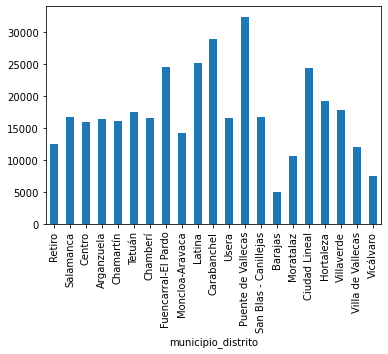

In [ ]:
madrid_covid.set_index('municipio_distrito')['casos_confirmados_totales'].plot(kind='bar')

In [ ]:
mean = madrid_covid["casos_confirmados_totales"].mean()
median = madrid_covid["casos_confirmados_totales"].median()
mode = madrid_covid["casos_confirmados_totales"].mode()
print("Mean: {}, Median: {}, Mode: {}".format(mean, median, mode))

Mean: 17382.238095238095, Median: 16486.0, Mode: 0     4907.0 
1     7441.0 
2     10609.0
3     11923.0
4     12414.0
5     14199.0
6     15821.0
7     15996.0
8     16282.0
9     16452.0
10    16486.0
11    16615.0
12    16636.0
13    17464.0
14    17744.0
15    19116.0
16    24269.0
17    24499.0
18    25016.0
19    28794.0
20    32344.0
dtype: float64


In [ ]:
# create map of Madrid using latitude and longitude values
district_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, district, confirmed in zip(madrid_covid['latitude'],madrid_covid['longitude'],madrid_covid['municipio_distrito'], madrid_covid['casos_confirmados_totales']):
    label = '{},  {} Confirmed cases'.format(district, confirmed)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(district_map)

district_map

In [ ]:
madrid_covid['municipio_distrito']

0                    Retiro
1                 Salamanca
2                    Centro
3                Arganzuela
4                 Chamartín
5                    Tetuán
6                  Chamberí
7       Fuencarral-El Pardo
8           Moncloa-Aravaca
9                    Latina
10              Carabanchel
11                    Usera
12       Puente de Vallecas
13    San Blas - Canillejas
14                  Barajas
15                Moratalaz
16            Ciudad Lineal
17                Hortaleza
18               Villaverde
19        Villa de Vallecas
20                Vicálvaro
Name: municipio_distrito, dtype: object

In [ ]:
madrid_covid.head()

,municipio_distrito,latitude,longitude,fecha_informe,casos_confirmados_ultimos_14dias,casos_confirmados_totales,poblacion_distrito,tasa_incidencia_acumulada_total
0,Retiro,40.408072,-3.676729,29/06/2021 12:04,105.0,12414.0,120238.0,"10314,06"
1,Salamanca,40.430000,-3.677778,29/06/2021 12:04,175.0,16615.0,147349.0,"11238,43"
2,Centro,40.415347,-3.707371,29/06/2021 12:04,173.0,15821.0,140360.0,"11258,58"
3,Arganzuela,40.402733,-3.695403,29/06/2021 12:04,206.0,16282.0,156010.0,"10460,78"
4,Chamartín,40.453333,-3.677500,29/06/2021 12:04,182.0,15996.0,147483.0,"10841,14"


Function that extracts the **category of the venue**

In [ ]:
def categories_type(row):
    categories_list = row['venue.categories']
    if len(categories_list)  == 0:
        return None
    else:
        return categories_list[0]['name']

In [ ]:
foursquare_venues=pd.DataFrame()
mdc = []

In [ ]:
for latitude, longitude, distr, conf in zip(madrid_covid['latitude'],madrid_covid['longitude'],madrid_covid['municipio_distrito'],madrid_covid['casos_confirmados_totales']):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            latitude,
            longitude,
            radius,
            LIMIT)
    results = requests.get(url).json()
    venues = pd.json_normalize(results['response']['groups'][0]['items'])
    filtered_columns = ['venue.id', 'venue.location.lat', 'venue.location.lng', 'venue.name', 'venue.categories']
    venues_df = venues[filtered_columns]
    venues_df['venue.categories'] = venues_df.apply(categories_type, axis=1)
    venues_df['district']=distr
    venues_df['confirmed']=conf
    mdc.append(venues_df)



Venues from the API Foursquare with each district and COVID confirmed cases

In [ ]:
foursquare_venues = pd.concat(mdc)
foursquare_venues.head()

,venue.id,venue.location.lat,venue.location.lng,venue.name,venue.categories,district,confirmed
0,4da9810d8154abafc2948f8e,40.410987,-3.680377,Rosaleda del Retiro,Garden,Retiro,12414.0
1,4d28cb43342d6dcb624dfcca,40.404065,-3.677902,El Rincón de Fogg,Burger Joint,Retiro,12414.0
2,4bc201b0f8219c741615b410,40.407648,-3.680188,Don Giovanni,Italian Restaurant,Retiro,12414.0
3,4e6276311838ad3d0eceb6c9,40.412714,-3.677826,Jardines de Cecilio Rodríguez,Garden,Retiro,12414.0
4,4bc8a39e6501c9b6b88f4029,40.406407,-3.681303,EFTI,Art Gallery,Retiro,12414.0


In [ ]:
foursquare_venues.shape

(1898, 7)

In [ ]:
print('{} venues were returned by Foursquare.'.format(foursquare_venues.shape[0]))

1898 venues were returned by Foursquare.


In [ ]:
foursquare_venues['venue.categories'].value_counts()

Spanish Restaurant    174
Restaurant            109
Hotel                  72
Park                   71
Tapas Restaurant       65
                     ... 
Soup Place              1
Motorcycle Shop         1
Board Shop              1
Arcade                  1
Gas Station             1
Name: venue.categories, Length: 214, dtype: int64

In [ ]:
# cafeteria venues
venues_cafeteria = foursquare_venues[foursquare_venues['venue.categories'] == 'Cafeteria']
venues_cafeteria

,venue.id,venue.location.lat,venue.location.lng,venue.name,venue.categories,district,confirmed
25,4b7137e0f964a520f23c2de3,40.479636,-3.707357,Starbucks CC La Vaguada,Cafeteria,Fuencarral-El Pardo,24499.0
28,4b6d7fddf964a52088782ce3,40.429069,-3.715079,Starbucks Princesa 40,Cafeteria,Moncloa-Aravaca,14199.0
14,59ea4524ccad6b7e88d32a86,40.391304,-3.701123,Starbucks Plaza Río 2,Cafeteria,Usera,16452.0
92,4b673c58f964a520fd422be3,40.462823,-3.636758,Starbucks CC Dreams,Cafeteria,Ciudad Lineal,24269.0
23,4b673c58f964a520fd422be3,40.462823,-3.636758,Starbucks CC Dreams,Cafeteria,Hortaleza,19116.0


Lets start by exploring just the first district in our dataframe using Foursquare API.

In [ ]:
district_name = madrid_data.loc[0, 'District']
district_lat = madrid_data.loc[0, 'District_Latitude']
district_long = madrid_data.loc[0, 'District_Longitude']

print("The district is {} and it's district's coordinates are {} latitude and {} longitude".format(district_name,
                                                                                                        district_lat, district_long))



The district is Centro and it's district's coordinates are 40.415347 latitude and -3.7073709999999997 longitude


In [ ]:
# API Foursquare
LIMIT = 100
radius = 1000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    district_lat,
    district_long,
    radius,
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=IYJ1TPEJFEWISEQRDNZNXO4HJQ0MTMY0AVDGBJBOLUEYAGH0&client_secret=HSVKU5JZT2OEKVIW33NFPEGPDFT4Z1OLKCY2FDFRFO023T4B&v=20180604&ll=40.415347,-3.7073709999999997&radius=1000&limit=100'

Using GET method to get the results

In [ ]:
results_bar = requests.get(url).json()
results_bar

{'meta': {'code': 200, 'requestId': '60ff67fa4c476f4096cc69a3'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Plaza Mayor',
  'headerFullLocation': 'Plaza Mayor, Madrid',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 239,
  'suggestedBounds': {'ne': {'lat': 40.42434700900001,
    'lng': -3.6955721797796866},
   'sw': {'lat': 40.406346990999985, 'lng': -3.719169820220313}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4adcda37f964a520193c21e3',
       'name': 'Plaza Mayor',
       'location': {'address': 'Pl. Mayor',
        'lat': 40.415526598647354,
        'lng': -3.7075061894121037,
        'distance': 23,
        'postalCode': '28012',
        'cc': 'ES

This function extracts the categories of venues

In [ ]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Cleaning the json and structure it into a pandas dataframe

In [ ]:
venues = results['response']['groups'][0]['items']

nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Mesón El Águila,Spanish Restaurant,40.401573,-3.607245
1,Heladería Sienna - Sienna Winter Café,Ice Cream Shop,40.402532,-3.606221
2,Parque de Valdebernardo,Park,40.397950,-3.606945
3,Ahorramás,Grocery Store,40.404239,-3.605553
4,La Madrina,Pizza Place,40.398139,-3.606602


In [ ]:
print("{} venues were returned for {} by Foursquare".format(len(nearby_venues), district_name))

72 venues were returned for Centro by Foursquare


Getting nearby venues for all districts by creating the function getNearbyVenues.This function extracts the venues data for the districts in Madrid

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):

    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District',
                  'Latitude',
                  'Longitude',
                  'Venue',
                  'Venue Latitude',
                  'Venue Longitude',
                  'Venue Category']

    return(nearby_venues)

In [ ]:
# we run the above function on each district and create a new dataframe called madrid_venues.
madrid_venues = getNearbyVenues(names=madrid_data['District'],
                                   latitudes=madrid_data['District_Latitude'],
                                   longitudes=madrid_data['District_Longitude']
                                  )

Centro
Centro
Centro
Centro
Centro
Centro
Arganzuela
Arganzuela
Arganzuela
Arganzuela
Arganzuela
Arganzuela
Arganzuela
Retiro
Retiro
Retiro
Retiro
Retiro
Retiro
Salamanca
Salamanca
Salamanca
Salamanca
Salamanca
Salamanca
Chamartin
Chamartin
Chamartin
Chamartin
Chamartin
Chamartin
Tetuan
Tetuan
Tetuan
Tetuan
Tetuan
Tetuan
Chamberi
Chamberi
Chamberi
Chamberi
Chamberi
Chamberi
Fuencarral - El Pardo
Fuencarral - El Pardo
Fuencarral - El Pardo
Fuencarral - El Pardo
Fuencarral - El Pardo
Fuencarral - El Pardo
Fuencarral - El Pardo
Fuencarral - El Pardo
Moncloa - Aravaca
Moncloa - Aravaca
Moncloa - Aravaca
Moncloa - Aravaca
Moncloa - Aravaca
Moncloa - Aravaca
Moncloa - Aravaca
Latina
Latina
Latina
Latina
Latina
Latina
Latina
Carabanchel
Carabanchel
Carabanchel
Carabanchel
Carabanchel
Carabanchel
Carabanchel
Usera
Usera
Usera
Usera
Usera
Usera
Usera
Puente de Vallecas
Puente de Vallecas
Puente de Vallecas
Puente de Vallecas
Puente de Vallecas
Puente de Vallecas
Moratalaz
Moratalaz
Moratalaz
Mo

In [ ]:
print(madrid_venues.shape)
madrid_venues.head()

(4707, 7)


,District,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Centro,40.415347,-3.707371,Plaza Mayor,40.415527,-3.707506,Plaza
1,Centro,40.415347,-3.707371,Mercado de San Miguel,40.415443,-3.708943,Market
2,Centro,40.415347,-3.707371,The Hat Madrid,40.414343,-3.707120,Hotel
3,Centro,40.415347,-3.707371,La Taberna de Mister Pinkleton,40.414536,-3.708108,Other Nightlife
4,Centro,40.415347,-3.707371,Plaza Menor,40.414192,-3.708494,Lounge


Counting venues grouped by district:

In [ ]:
madrid_venues.groupby('District').count()

,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,
Arganzuela,595,595,595,595,595,595
Barajas,155,155,155,155,155,155
Carabanchel,63,63,63,63,63,63
Centro,600,600,600,600,600,600
Chamartin,336,336,336,336,336,336
Chamberi,600,600,600,600,600,600
Ciudad Lineal,234,234,234,234,234,234
Fuencarral - El Pardo,312,312,312,312,312,312
Hortaleza,108,108,108,108,108,108


In [ ]:
print("There are {} unique categories".format(len(madrid_venues['Venue Category'].unique())))

There are 165 unique categories


In [ ]:
# one hot encoding
madrid_onehot = pd.get_dummies(madrid_venues[['Venue Category']], prefix="", prefix_sep="")

# add disctrict column back to dataframe
madrid_onehot['District'] = madrid_venues['District']

# move neighborhood column to the first column
fixed_columns = [madrid_onehot.columns[-1]] + list(madrid_onehot.columns[:-1])
madrid_onehot = madrid_onehot[fixed_columns]

madrid_onehot.head(5)

,District,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Bakery,Bar,Beer Bar,Beer Garden,Big Box Store,Bistro,Board Shop,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Cafeteria,Café,Candy Store,Cantonese Restaurant,Chinese Restaurant,Chocolate Shop,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Department Store,Dessert Shop,Diner,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Food,Food & Drink Shop,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,German Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hostel,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Liquor Store,Lounge,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,Nightclub,Noodle House,Opera House,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Park,Pastry Shop,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Pub,Ramen Restaurant,Resort,Restaurant,Road,Salad Place,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shopping Mall,Smoothie Shop,Snack Place,Soccer Field,South American Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trade School,Train,Train Station,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Wine Bar,Wine Shop,Women's Store
0,Centro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Centro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Centro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Centro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Centro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [ ]:
madrid_grouped = madrid_onehot.groupby('District').mean().reset_index()
madrid_grouped

,District,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Bakery,Bar,Beer Bar,Beer Garden,Big Box Store,Bistro,Board Shop,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Cafeteria,Café,Candy Store,Cantonese Restaurant,Chinese Restaurant,Chocolate Shop,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Department Store,Dessert Shop,Diner,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Food,Food & Drink Shop,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,German Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hostel,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Liquor Store,Lounge,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,Nightclub,Noodle House,Opera House,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Park,Pastry Shop,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Pub,Ramen Restaurant,Resort,Restaurant,Road,Salad Place,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shopping Mall,Smoothie Shop,Snack Place,Soccer Field,South American Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trade School,Train,Train Station,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Wine Bar,Wine Shop,Women's Store
0,Arganzuela,0.00,0.023529,0.000000,0.000000,0.00,0.00000,0.000000,0.011765,0.000000,0.00000,0.000000,0.058824,0.000000,0.011765,0.023529,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.023529,0.011765,0.000000,0.023529,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.011765,0.000000,0.011765,0.000000,0.000000,0.011765,0.011765,0.000000,0.00,0.011765,0.000000,0.000000,0.000000,0.011765,0.000000,0.00000,0.000000,0.000000,0.000000,0.011765,0.000000,0.023529,0.011765,0.000000,0.000000,0.011765,0.000000,0.00000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00000,0.0,0.011765,0.000000,0.000000,0.00000,0.00000,0.070588,0.011765,0.035294,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.00,0.00,0.023529,0.000000,0.00000,0.00,0.011765,0.011765,0.000000,0.000000,0.000000,0.000000,0.011765,0.000000,0.000000,0.000000,0.023529,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.011765,0.00,0.011765,0.011765,0.000000,0.000000,0.00,0.011765,0.00,0.011765,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.023529,0.000,0.000000,0.011765,0.00000,0.000000,0.000000,0.00000,0.117647,0.00,0.000000,0.011765,0.000000,0.011765,0.000000,0.000000,0.00,0.011765,0.000000,0.000000,0.00,0.094118,0.000000,0.000000,0.011765,0.000000,0.047059,0.011765,0.00,0.011765,0.000000,0.011765,0.011765,0.000000,0.011765,0.0,0.011765,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
1,Barajas,0.00,0.000000,0.032258,0.000000,0.00,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.032258,0.000000,0.000000,0.000000,0.032258,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.032258,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032258,0.00,0.

Displaying the top 5 venues of all districts

In [ ]:
num_top_venues = 5

for n in madrid_grouped['District']:
    print("----"+n+"----")
    temp = madrid_grouped[madrid_grouped['District']==n].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Arganzuela----
                venue  freq
0  Restaurant          0.12
1  Spanish Restaurant  0.09
2  Grocery Store       0.07
3  Bakery              0.06
4  Tapas Restaurant    0.05


----Barajas----
                venue  freq
0  Hotel               0.19
1  Restaurant          0.13
2  Spanish Restaurant  0.10
3  Coffee Shop         0.06
4  Tapas Restaurant    0.06


----Carabanchel----
                  venue  freq
0  Plaza                 0.11
1  Bakery                0.11
2  Fast Food Restaurant  0.11
3  Nightclub             0.11
4  Soccer Field          0.11


----Centro----
                venue  freq
0  Spanish Restaurant  0.13
1  Tapas Restaurant    0.12
2  Plaza               0.10
3  Ice Cream Shop      0.04
4  Hostel              0.04


----Chamartin----
                venue  freq
0  Restaurant          0.14
1  Spanish Restaurant  0.14
2  Café                0.05
3  Bakery              0.05
4  Grocery Store       0.05


----Chamberi----
                venue  freq
0  Sp

Putting the previous into a pandas dataframe

In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)

    return row_categories_sorted.index.values[0:num_top_venues]

Let's create the new dataframe and display the top 10 venues for each neighborhood

In [ ]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['District'] = madrid_grouped['District']

for ind in np.arange(madrid_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(madrid_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arganzuela,Restaurant,Spanish Restaurant,Grocery Store,Bakery,Tapas Restaurant,Gym / Fitness Center,Beer Garden,Market,Falafel Restaurant,Burger Joint
1,Barajas,Hotel,Restaurant,Spanish Restaurant,Coffee Shop,Tapas Restaurant,Bar,Fast Food Restaurant,Brewery,Mexican Restaurant,Café
2,Carabanchel,Pizza Place,Nightclub,Fast Food Restaurant,Burger Joint,Tapas Restaurant,Bakery,Soccer Field,Metro Station,Plaza,Diner
3,Centro,Spanish Restaurant,Tapas Restaurant,Plaza,Hostel,Ice Cream Shop,Bookstore,Hotel,Pastry Shop,Cocktail Bar,Gym / Fitness Center
4,Chamartin,Spanish Restaurant,Restaurant,Bakery,Grocery Store,Tapas Restaurant,Café,Gastropub,Park,Coffee Shop,Japanese Restaurant
5,Chamberi,Spanish Restaurant,Restaurant,Bar,Brewery,Italian Restaurant,Japanese Restaurant,Café,Plaza,Mexican Restaurant,Tapas Restaurant
6,Ciudad Lineal,Restaurant,Spanish Restaurant,Park,Grocery Store,Argentinian Restaurant,Gastropub,Tapas Restaurant,Pharmacy,Café,Bus Line
7,Fuencarral - El Pardo,Clothing Store,Burger Joint,Tapas Restaurant,Fast Food Restaurant,Italian Restaurant,Shopping Mall,Spanish Restaurant,Big Box Store,Flea Market,Boutique
8,Hortaleza,Breakfast Spot,Supermarket,Pizza Place,Sandwich Place,Pub,Spanish Restaurant,Bakery,Plaza,Chinese Restaurant,Restaurant
9,Latina,Pizza Place,Fast Food Restaurant,Park,Grocery Store,Train Station,Arts & Crafts Store,Asian Restaurant,Falafel Restaurant,Metro Station,Bakery


### Cluster Districts

Run k-means to cluster districts.

The following is to determine how many clusters should we use, for this we will use the Silhouette Score - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

In [ ]:
def plot(x, y):
    fig = plt.figure(figsize=(12,6))
    plt.plot(x, y, 'o-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Scores')
    plt.title('Checking Optimum Number of Clusters')
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

In [ ]:
maxk = 15
scores = []
kval = []

for k in range(2, maxk+1):
    cl_df = madrid_grouped.drop('District', axis=1)
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=0).fit_predict(cl_df) #Choose any random_state

    score = silhouette_score(cl_df, kmeans, metric='euclidean', random_state=0)
    kval.append(k)
    scores.append(score)

[0.1903125726032766, 0.1620096375806738, 0.1940931157107913, 0.18574859973350114, 0.15799897660811957, 0.14931739548789957, 0.11691430041648038, 0.15547870618207524, 0.14334680215501786, 0.041599156450781376, 0.04124564442032303, 0.04168433945809237, 0.029124446627720606, 0.032561698923450386]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


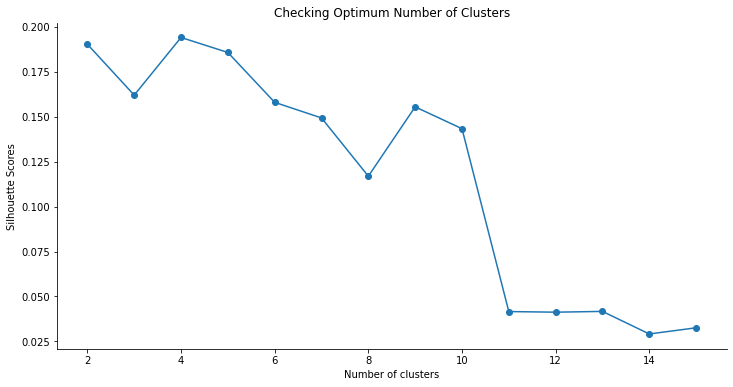

In [ ]:
print(scores)
print(kval)
plot(kval, scores)

Acording to the previous we can use 3 or 4 clusters given that it provides the highest silhouette score. Also note that it decreases as the number of clusters increases  

In [ ]:
# set number of clusters
kclusters = 4

madrid_grouped_clustering = madrid_grouped.drop('District', 1)

# run k-means clustering

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(madrid_grouped_clustering)

# check cluster labels generated for each row in the dataframe

kmeans.labels_[0:10]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 3])

In [ ]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

madrid_merged = madrid_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
madrid_merged = madrid_merged.join(neighborhoods_venues_sorted.set_index('District'), on='District')

madrid_merged.head() # check the last columns!

,District,Neighborhood,District_Latitude,District_Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Centro,Palacio,40.415347,-3.707371,0,Spanish Restaurant,Tapas Restaurant,Plaza,Hostel,Ice Cream Shop,Bookstore,Hotel,Pastry Shop,Cocktail Bar,Gym / Fitness Center
1,Centro,Embajadores,40.415347,-3.707371,0,Spanish Restaurant,Tapas Restaurant,Plaza,Hostel,Ice Cream Shop,Bookstore,Hotel,Pastry Shop,Cocktail Bar,Gym / Fitness Center
2,Centro,Cortes,40.415347,-3.707371,0,Spanish Restaurant,Tapas Restaurant,Plaza,Hostel,Ice Cream Shop,Bookstore,Hotel,Pastry Shop,Cocktail Bar,Gym / Fitness Center
3,Centro,Justicia,40.415347,-3.707371,0,Spanish Restaurant,Tapas Restaurant,Plaza,Hostel,Ice Cream Shop,Bookstore,Hotel,Pastry Shop,Cocktail Bar,Gym / Fitness Center
4,Centro,Universidad,40.415347,-3.707371,0,Spanish Restaurant,Tapas Restaurant,Plaza,Hostel,Ice Cream Shop,Bookstore,Hotel,Pastry Shop,Cocktail Bar,Gym / Fitness Center


In [ ]:
# Had to do this the column's names were giving error
madrid_data = madrid_data.rename(columns={'DISTRICT': 'District', 'NEIGHBORHOOD':'Neighborhood', 'DISTRICT_LATITUDE':'District_Latitude',
                                  'DISTRICT_LONGITUDE':'District_Longitude'})
madrid_data

,District,Neighborhood,District_Latitude,District_Longitude
0,Centro,Palacio,40.415347,-3.707371
1,Centro,Embajadores,40.415347,-3.707371
2,Centro,Cortes,40.415347,-3.707371
3,Centro,Justicia,40.415347,-3.707371
4,Centro,Universidad,40.415347,-3.707371
5,Centro,Sol,40.415347,-3.707371
6,Arganzuela,Imperial,40.402733,-3.695403
7,Arganzuela,Acacias,40.402733,-3.695403
8,Arganzuela,Chopera,40.402733,-3.695403
9,Arganzuela,Legazpi,40.402733,-3.695403


Finally, let's visualize the resulting clusters

In [ ]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(madrid_merged['District_Latitude'], madrid_merged['District_Longitude'], madrid_merged['District'], madrid_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

### Cluster 1

In [ ]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 0, madrid_merged.columns[[0] + [1] + list(range(5, madrid_merged.shape[1]))]]

,District,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Centro,Palacio,Spanish Restaurant,Tapas Restaurant,Plaza,Hostel,Ice Cream Shop,Bookstore,Hotel,Pastry Shop,Cocktail Bar,Gym / Fitness Center
1,Centro,Embajadores,Spanish Restaurant,Tapas Restaurant,Plaza,Hostel,Ice Cream Shop,Bookstore,Hotel,Pastry Shop,Cocktail Bar,Gym / Fitness Center
2,Centro,Cortes,Spanish Restaurant,Tapas Restaurant,Plaza,Hostel,Ice Cream Shop,Bookstore,Hotel,Pastry Shop,Cocktail Bar,Gym / Fitness Center
3,Centro,Justicia,Spanish Restaurant,Tapas Restaurant,Plaza,Hostel,Ice Cream Shop,Bookstore,Hotel,Pastry Shop,Cocktail Bar,Gym / Fitness Center
4,Centro,Universidad,Spanish Restaurant,Tapas Restaurant,Plaza,Hostel,Ice Cream Shop,Bookstore,Hotel,Pastry Shop,Cocktail Bar,Gym / Fitness Center
5,Centro,Sol,Spanish Restaurant,Tapas Restaurant,Plaza,Hostel,Ice Cream Shop,Bookstore,Hotel,Pastry Shop,Cocktail Bar,Gym / Fitness Center
6,Arganzuela,Imperial,Restaurant,Spanish Restaurant,Grocery Store,Bakery,Tapas Restaurant,Gym / Fitness Center,Beer Garden,Market,Falafel Restaurant,Burger Joint
7,Arganzuela,Acacias,Restaurant,Spanish Restaurant,Grocery Store,Bakery,Tapas Restaurant,Gym / Fitness Center,Beer Garden,Market,Falafel Restaurant,Burger Joint
8,Arganzuela,Chopera,Restaurant,Spanish Restaurant,Grocery Store,Bakery,Tapas Restaurant,Gym / Fitness Center,Beer Garden,Market,Falafel Restaurant,Burger Joint
9,Arganzuela,Legazpi,Restaurant,Spanish Restaurant,Grocery Store,Bakery,Tapas Restaurant,Gym / Fitness Center,Beer Garden,Market,Falafel Restaurant,Burger Joint


### Cluster 2

In [ ]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 1, madrid_merged.columns[[0] + [1] + list(range(5, madrid_merged.shape[1]))]]

,District,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
65,Carabanchel,Comillas,Pizza Place,Nightclub,Fast Food Restaurant,Burger Joint,Tapas Restaurant,Bakery,Soccer Field,Metro Station,Plaza,Diner
66,Carabanchel,Opañel,Pizza Place,Nightclub,Fast Food Restaurant,Burger Joint,Tapas Restaurant,Bakery,Soccer Field,Metro Station,Plaza,Diner
67,Carabanchel,San Isidro,Pizza Place,Nightclub,Fast Food Restaurant,Burger Joint,Tapas Restaurant,Bakery,Soccer Field,Metro Station,Plaza,Diner
68,Carabanchel,Vista Alegre,Pizza Place,Nightclub,Fast Food Restaurant,Burger Joint,Tapas Restaurant,Bakery,Soccer Field,Metro Station,Plaza,Diner
69,Carabanchel,Puerta Bonita,Pizza Place,Nightclub,Fast Food Restaurant,Burger Joint,Tapas Restaurant,Bakery,Soccer Field,Metro Station,Plaza,Diner
70,Carabanchel,Buenavista,Pizza Place,Nightclub,Fast Food Restaurant,Burger Joint,Tapas Restaurant,Bakery,Soccer Field,Metro Station,Plaza,Diner
71,Carabanchel,Abrantes,Pizza Place,Nightclub,Fast Food Restaurant,Burger Joint,Tapas Restaurant,Bakery,Soccer Field,Metro Station,Plaza,Diner
85,Moratalaz,Pavones,Bar,Pizza Place,Ice Cream Shop,Food Truck,Café,Brewery,Nightclub,Bakery,Soccer Field,Plaza
86,Moratalaz,Horcajo,Bar,Pizza Place,Ice Cream Shop,Food Truck,Café,Brewery,Nightclub,Bakery,Soccer Field,Plaza
87,Moratalaz,Marroquina,Bar,Pizza Place,Ice Cream Shop,Food Truck,Café,Brewery,Nightclub,Bakery,Soccer Field,Plaza


### Cluster 3

In [ ]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 2, madrid_merged.columns[[0] + [1] + list(range(5, madrid_merged.shape[1]))]]

,District,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
106,Villaverde,"Villaverde Alto, Casco Histórico de Villaverde",Pizza Place,Train,Plaza,Diner,Spanish Restaurant,Grocery Store,Dog Run,Farmers Market,Falafel Restaurant,Fabric Shop
107,Villaverde,San Cristóbal,Pizza Place,Train,Plaza,Diner,Spanish Restaurant,Grocery Store,Dog Run,Farmers Market,Falafel Restaurant,Fabric Shop
108,Villaverde,Butarque,Pizza Place,Train,Plaza,Diner,Spanish Restaurant,Grocery Store,Dog Run,Farmers Market,Falafel Restaurant,Fabric Shop
109,Villaverde,Los Rosales,Pizza Place,Train,Plaza,Diner,Spanish Restaurant,Grocery Store,Dog Run,Farmers Market,Falafel Restaurant,Fabric Shop
110,Villaverde,Los Ángeles,Pizza Place,Train,Plaza,Diner,Spanish Restaurant,Grocery Store,Dog Run,Farmers Market,Falafel Restaurant,Fabric Shop


### Cluster 4

In [ ]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 3, madrid_merged.columns[[0] + [1] + list(range(5, madrid_merged.shape[1]))]]

,District,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
58,Latina,Cármenes,Pizza Place,Fast Food Restaurant,Park,Grocery Store,Train Station,Arts & Crafts Store,Asian Restaurant,Falafel Restaurant,Metro Station,Bakery
59,Latina,Puerta del Ángel,Pizza Place,Fast Food Restaurant,Park,Grocery Store,Train Station,Arts & Crafts Store,Asian Restaurant,Falafel Restaurant,Metro Station,Bakery
60,Latina,Lucero,Pizza Place,Fast Food Restaurant,Park,Grocery Store,Train Station,Arts & Crafts Store,Asian Restaurant,Falafel Restaurant,Metro Station,Bakery
61,Latina,Aluche,Pizza Place,Fast Food Restaurant,Park,Grocery Store,Train Station,Arts & Crafts Store,Asian Restaurant,Falafel Restaurant,Metro Station,Bakery
62,Latina,Campamento,Pizza Place,Fast Food Restaurant,Park,Grocery Store,Train Station,Arts & Crafts Store,Asian Restaurant,Falafel Restaurant,Metro Station,Bakery
63,Latina,Cuatro Vientos,Pizza Place,Fast Food Restaurant,Park,Grocery Store,Train Station,Arts & Crafts Store,Asian Restaurant,Falafel Restaurant,Metro Station,Bakery
64,Latina,Águilas,Pizza Place,Fast Food Restaurant,Park,Grocery Store,Train Station,Arts & Crafts Store,Asian Restaurant,Falafel Restaurant,Metro Station,Bakery
118,San Blas - Canillejas,Simancas,Metro Station,Asian Restaurant,Shopping Mall,Supermarket,Snack Place,Pizza Place,Gas Station,Grocery Store,Gym,Fabric Shop
119,San Blas - Canillejas,Hellín,Metro Station,Asian Restaurant,Shopping Mall,Supermarket,Snack Place,Pizza Place,Gas Station,Grocery Store,Gym,Fabric Shop
120,San Blas - Canillejas,Amposta,Metro Station,Asian Restaurant,Shopping Mall,Supermarket,Snack Place,Pizza Place,Gas Station,Grocery Store,Gym,Fabric Shop


## Results and discussion

By segmenting into clusters we can distinguish the different districts of the city of Madrid and their respective venues according to Foursquare, by using Silhouette Score the best number of clusters were 3 and 4, in this exercise we used 4 clusters.

When analyzing the different clusters, cluster number 1 has in fourth, sixth, seventh, ninth and tenth place categories cafeteria and derivatives, it is also cluster number 1 the longest one where more districts and neighborhoods are located.
According to the above Madrid is a city where there are quite a few cafeteria type places partly also because of its strong tourist area especially in the central and most touristic part of the city, districts such as Chamartin, Barajas, Hortaleza, Puente de Vallecas have quite a few venues in cafeteria.

A good option for a possible interested in starting a cafeteria type project would be in the mentioned districts due to its touristic nature, for example Moratalaz presents in the second cluster a fifth place in cafeteria venues.

**This is the cluster number 1 wich has the most cafeteria venue:**

In [ ]:
cafeteria_districts = madrid_merged.loc[madrid_merged['Cluster Labels'] == 0, madrid_merged.columns[[0, 1, 2, 3] + list(range(5, madrid_merged.shape[1]))]]
cafeteria_districts.head()

,District,Neighborhood,District_Latitude,District_Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Centro,Palacio,40.415347,-3.707371,Spanish Restaurant,Tapas Restaurant,Plaza,Hostel,Ice Cream Shop,Bookstore,Hotel,Pastry Shop,Cocktail Bar,Gym / Fitness Center
1,Centro,Embajadores,40.415347,-3.707371,Spanish Restaurant,Tapas Restaurant,Plaza,Hostel,Ice Cream Shop,Bookstore,Hotel,Pastry Shop,Cocktail Bar,Gym / Fitness Center
2,Centro,Cortes,40.415347,-3.707371,Spanish Restaurant,Tapas Restaurant,Plaza,Hostel,Ice Cream Shop,Bookstore,Hotel,Pastry Shop,Cocktail Bar,Gym / Fitness Center
3,Centro,Justicia,40.415347,-3.707371,Spanish Restaurant,Tapas Restaurant,Plaza,Hostel,Ice Cream Shop,Bookstore,Hotel,Pastry Shop,Cocktail Bar,Gym / Fitness Center
4,Centro,Universidad,40.415347,-3.707371,Spanish Restaurant,Tapas Restaurant,Plaza,Hostel,Ice Cream Shop,Bookstore,Hotel,Pastry Shop,Cocktail Bar,Gym / Fitness Center


In [ ]:
cafe_locations = folium.Map(location=[latitude, longitude], zoom_start=10)
tooltip = "Click me!"


for lat, lng, location, neighborhood in zip(cafeteria_districts['District_Latitude'], cafeteria_districts['District_Longitude'],
                                            cafeteria_districts['District'], cafeteria_districts['Neighborhood']):
    label = '{}, {}'.format(neighborhood, location)
    folium.Marker([lat, lng], popup='{} has geographical coordinates ({:.4f}, {:.4f})'.format(label, lat, lng),
                  icon=folium.Icon(color='lightred')).add_to(cafe_locations)

    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(cafe_locations)

cafe_locations

## Conclusion

For those interested this exercise shows on the map where most coffee is consumed in the most touristic area of Madrid, but at the same time there are areas where there are many confirmed cases of COVID, for example Puente de Vallecas with more than 30000 confirmed cases is a good district due to the venues in cafeteria but is well above the average of infections, Moratalaz can be interesting as it does not have as many infections as other districts and Barajas also has the lowest number of infections and has a fourth place in venus of cafeteria.


Villa de Vallecas and Hortaleza have in first place the Breakfast Spot venue which can be a good idea for a stakeholder as it can be related to cafeteria but at the same time they are districts with high confirmed cases.
Therefore cluster number 1 is indicated for a new coffee shop or cafeteria due to its touristic nature and the amount of venues related to groceries, restaurants, breakfast, etc, that this cluster has but without neglecting the COVID issue.